## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - KNN*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [2]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
#import dtreeviz.trees as dtreeviz
import pydotplus
from IPython.display import Image

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from six import StringIO

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##### Lectura del dataset:

In [3]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

---

## Armado y entrenamiento del modelo

##### Preparación de features:

In [4]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

In [5]:
cols_categorical = ['room_type_unchanged',
                    'country_encoded',
                   'customer_type_Group',
                   'customer_type_Transient',
                   'customer_type_Transient-Party',
                   'deposit_type_Non Refund',
                   'deposit_type_Refundable',
                   'hotel_Resort Hotel',
                   'distribution_channel_Direct',
                   'distribution_channel_GDS',
                   'distribution_channel_TA/TO',
                   'distribution_channel_Undefined',
                   'market_segment_Complementary',
                   'market_segment_Corporate',
                   'market_segment_Direct',
                   'market_segment_Groups',
                   'market_segment_Offline TA/TO',
                   'market_segment_Online TA',
                   'market_segment_Undefined',
                   'meal_FB',
                   'meal_HB',
                   'meal_SC',
                   'meal_Undefined']

In [6]:
cols_to_normalize =[col for col in hotel_train.columns if col not in cols_categorical]

In [7]:
cols_to_normalize.remove('is_canceled')
cols_to_normalize

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests']

##### Train-Test Split:

In [8]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


#### Normalización:
Versión estandarizada con $\frac{x_i - mean(x)}{stdev(x)}$

In [9]:
x_train_to_norm = pd.DataFrame(x_train, columns=features).drop(cols_categorical, axis=1)
x_test_to_norm = pd.DataFrame(x_test, columns=features).drop(cols_categorical, axis=1)

In [10]:
x_train_categorical = pd.DataFrame(x_train, columns=features).drop(cols_to_normalize, axis=1)
x_test_categorical = pd.DataFrame(x_test, columns=features).drop(cols_to_normalize, axis=1)

In [11]:
# Aplicar la transformación de escalado de características solo a las columnas seleccionadas
stand_scaler = StandardScaler()
x_train_norm_scaled = stand_scaler.fit_transform(x_train_to_norm)
x_test_norm_scaled = stand_scaler.transform(x_test_to_norm)

# Convertir las matrices escaladas nuevamente en DataFrames
x_train_norm_scaled = pd.DataFrame(x_train_norm_scaled, columns=cols_to_normalize)
x_test_norm_scaled = pd.DataFrame(x_test_norm_scaled, columns=cols_to_normalize)

# Agregar las columnas categoricas a las matrices escaladas
x_train_norm = pd.concat([x_train_norm_scaled, x_train_categorical], axis=1)
x_test_norm = pd.concat([x_test_norm_scaled, x_test_categorical], axis=1)

#### KNN:

In [12]:
# Cantidad de combinaciones
n=5

# Conjunto de rangos a optimizar cada parámetro
params_grid = {'algorithm': ['ball_tree','kd_tree','brute'],
               'leaf_size': list(range(1,20)),
               'metric': ['minkowski'],
               'n_jobs': [-1],
               'n_neighbors': list(range(2,30)),
               'p': [1,2],
               'weights': ['uniform','distance']}

# Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=10)

# Clasificador
base_knn = KNeighborsClassifier() 

# Elegimos la metrica a utilizar
scorer_fn = make_scorer(sk.metrics.f1_score)

# Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_knn,
                              param_distributions=params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

# Buscamos los hiperparámetros que optimizan la metrica
randomcv.fit(x_train_norm,y_train);

In [13]:
print('Mejores parámetros: ', randomcv.best_params_)
print('Mejor score: ', randomcv.best_score_)

Mejores parámetros:  {'weights': 'distance', 'p': 1, 'n_neighbors': 21, 'n_jobs': -1, 'metric': 'minkowski', 'leaf_size': 2, 'algorithm': 'ball_tree'}
Mejor score:  0.8438540386171987


In [14]:
# Cada valor representa F1 score, la cantidad varia por el parametro n
randomcv.cv_results_['mean_test_score']

array([0.82927442, 0.7999826 , 0.84380273, 0.81262334, 0.81473083,
       0.81591165, 0.84385404, 0.81259333, 0.83900481, 0.80967056])

#### Creación del modelo con los mejores parámetros:

In [15]:
# Se crea un objeto DecisionTreeClassifier con los mejores hiperparámetros encontrados
model_knn = KNeighborsClassifier(**randomcv.best_params_)

# Entrenamos el modelo
model_knn.fit(x_train_norm, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=2, n_jobs=-1,
                     n_neighbors=21, p=1, weights='distance')

---

## Análisis del modelo KNN

#### Reporte de clasificación y matriz de confusión:

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6033
           1       0.84      0.84      0.84      6138

    accuracy                           0.84     12171
   macro avg       0.84      0.84      0.84     12171
weighted avg       0.84      0.84      0.84     12171



Text(50.722222222222214, 0.5, 'True')

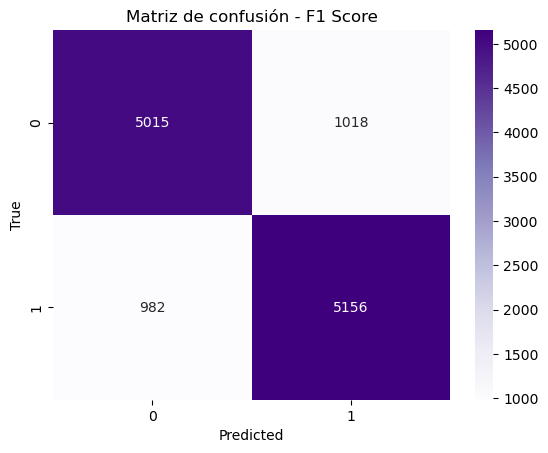

In [16]:
# Hacemos predicción sobre el set de evaluacion
y_pred = model_knn.predict(x_test_norm)

#Reporte de Clasificación
print(classification_report(y_test,y_pred))

#Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Purples',annot=True,fmt='g')
plt.title("Matriz de confusión - F1 Score")
plt.xlabel('Predicted')
plt.ylabel('True')

Score de cada split:

In [17]:
results = cross_validate(model_knn, x_train_norm, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True)

metricsCV = results['test_score']
metricsCV

array([0.8518369 , 0.83677222, 0.84701569, 0.85111612, 0.84673011,
       0.83633421, 0.84842401, 0.83844747, 0.84133143, 0.84053224])

#### Score de accuracy:

In [18]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 83.57%


#### Gráfico del boxplot de F1 Score:

<Axes: >

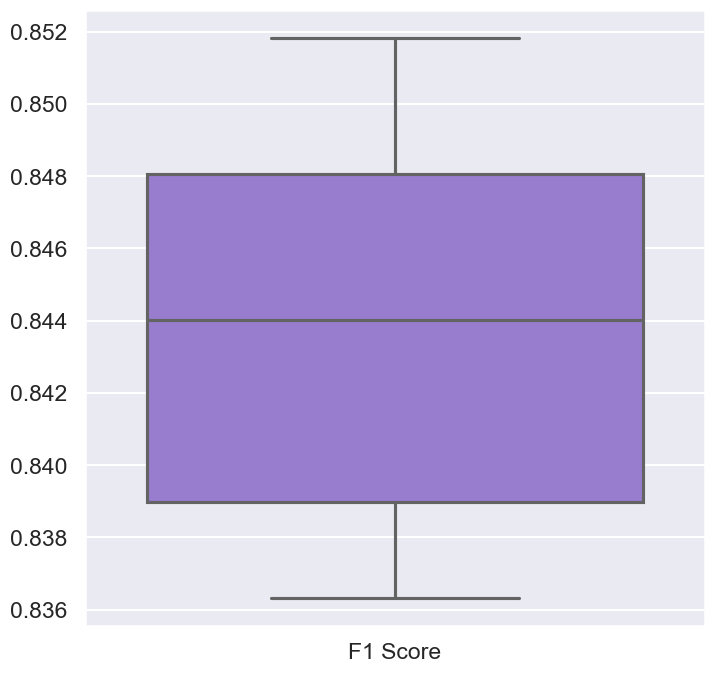

In [19]:
metric_labelsCV = ['F1 Score']*len(metricsCV)
sns.set_context('talk')
sns.set_style("darkgrid")
plt.figure(figsize=(8,8))
sns.boxplot(x=metric_labelsCV, y=metricsCV, color='mediumpurple')

#### Gráfico de curva ROC:

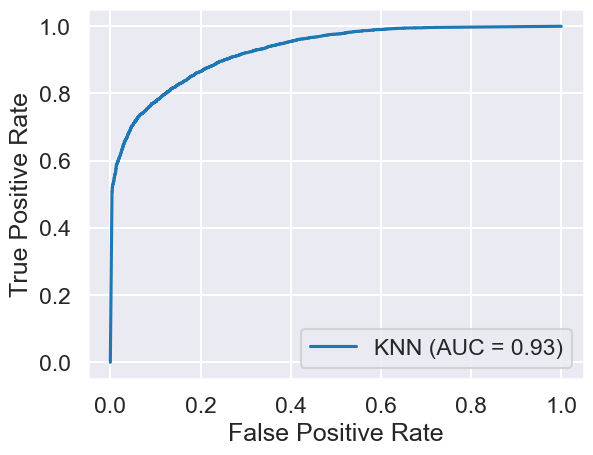

In [26]:
y_pred = model_knn.predict_proba(x_test_norm)[:, 1]  # obtener las probabilidades para la clase positiva
fpr, tpr, _ = roc_curve(y_test, y_pred) # FPR y TPR son acrónimos de "False Positive Rate" y "True Positive Rate"
roc_auc = roc_auc_score(y_test, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN').plot()
plt.legend(loc="lower right")  # agregar leyenda en la esquina inferior derecha
plt.show()

---

## Aplicación del modelo al dataset de test

##### Lectura del dataset de test preprocesado:

In [21]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [22]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [31]:
x_test_final = hotel_test[features]
x_test_final_cat = x_test_final[cols_categorical].copy()
x_test_final_cat.columns = cols_categorical

x_test_final_norm = pd.DataFrame(data=stand_scaler.transform(x_test_final[cols_to_normalize].copy()))
x_test_final_norm.columns = cols_to_normalize

In [32]:
y_pred_final = model_knn.predict(pd.concat([x_test_final_norm, x_test_final_cat], axis=1))

In [33]:
counts = np.bincount(y_pred_final)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción: 
No cancela: 13148
Cancela: 13387
Porceentaje de cancelaciones: 50.45%


In [34]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_knn_n10_split10.csv', index=False)

---

## Exportación del modelo

In [35]:
dump(model_knn, open('./modelos/model_knn_randomcv.pkl', 'wb'))